In [76]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib.pyplot import rc_context

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.3 scipy==1.6.3 pandas==1.1.4 scikit-learn==0.24.2 statsmodels==0.12.2


In [36]:
results_file = 'data/write/pbmc3k.h5ad'  # the file that will store the analysis results

In [37]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [38]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [39]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


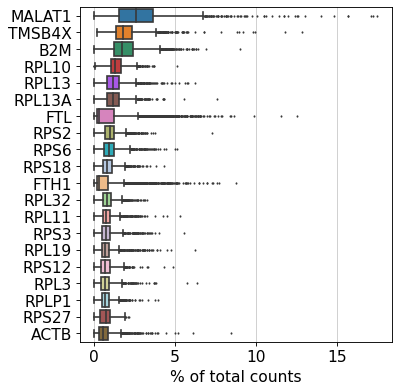

In [40]:
#Preprocessing; Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [41]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [42]:
# QC using mitochondrial genes - High proportions are indicative of poor-quality cells possibly because 
#  of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger
# than individual transcript molecules and less likely to escape through tears in the cell membrane
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

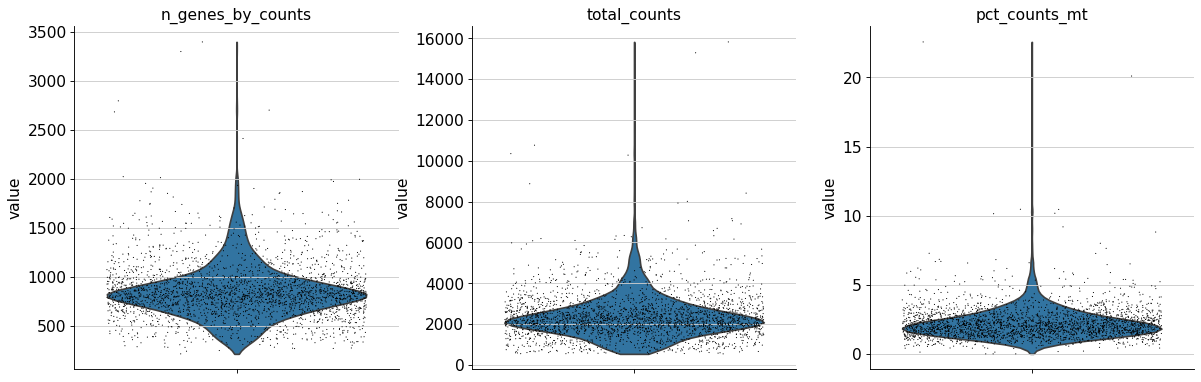

In [43]:
# Compute quality measures
# the number of genes expressed in the count matrix
# the total counts per cell
# the percentage of counts in mitochondrial genes
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

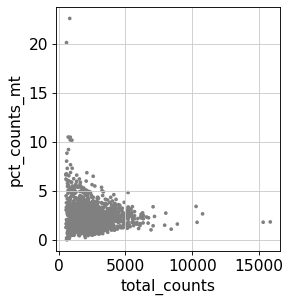

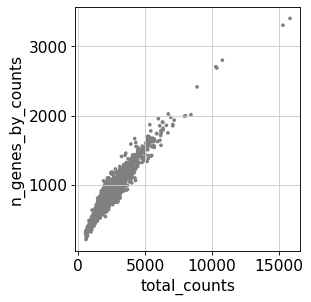

In [44]:
#Remove cells that have too many mitochondrial genes expressed or too many total counts:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [45]:
# Filtering by sclicing the anndata object
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [46]:
#Normalise the data
#Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

/home/savita/.local/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


In [47]:
#Log-normalise the data
sc.pp.log1p(adata)

In [48]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


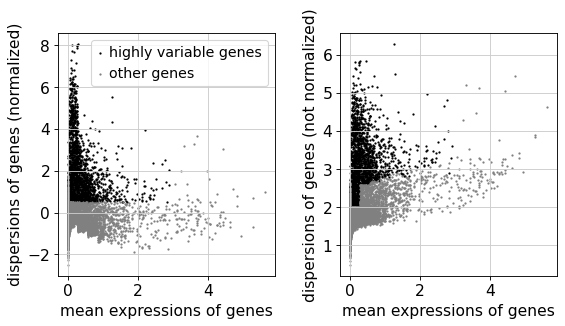

In [49]:
sc.pl.highly_variable_genes(adata)

In [50]:
#Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use 
#in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object
adata.raw = adata

In [51]:
#Filtering
adata = adata[:, adata.var.highly_variable]

In [52]:
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. 
# Scale the data to unit variance.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


In [53]:
#Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

In [54]:
#PCA analysis
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


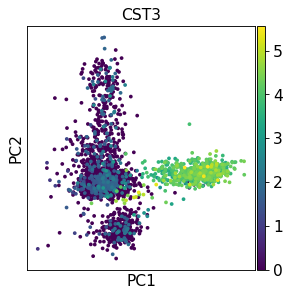

In [55]:
sc.pl.pca(adata, color='CST3')


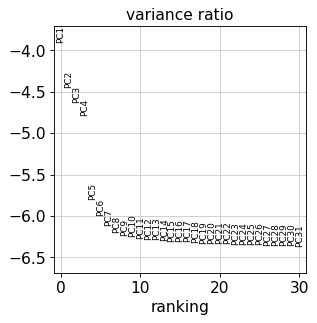

In [25]:
#Inspecting the contribution of single PCs to the total variance in the data. This gives us information about how many 
# PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function 
#sc.tl.louvain() or tSNE sc.tl.tsne()
sc.pl.pca_variance_ratio(adata, log=True)

In [56]:
adata.write(results_file)

In [57]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [73]:
#new dataset from scanpy to demo the core plotting funcations
pbmc = sc.datasets.pbmc68k_reduced()

In [74]:
pbmc

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

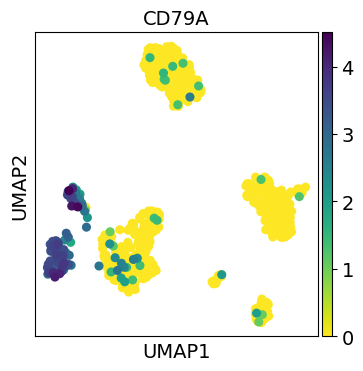

In [77]:
# rc_context is used for the figure size, in this case 4x4
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(pbmc, color='CD79A')

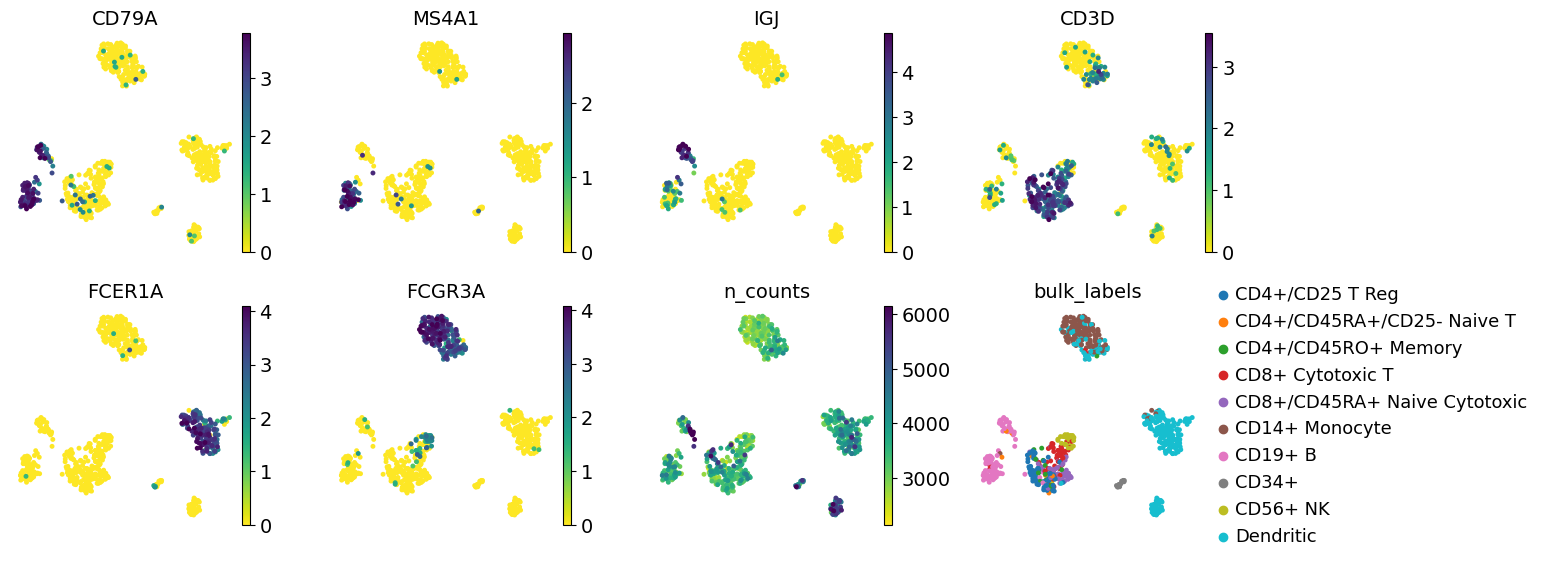

In [78]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(pbmc, color=['CD79A', 'MS4A1', 'IGJ', 'CD3D', 'FCER1A', 'FCGR3A', 'n_counts', 'bulk_labels'], s=50, frameon=False, ncols=4, vmax='p99')

In [80]:
# compute clusters using the leiden method and store the results with the name `clusters`
sc.tl.leiden(pbmc, key_added='clusters', resolution=0.5)

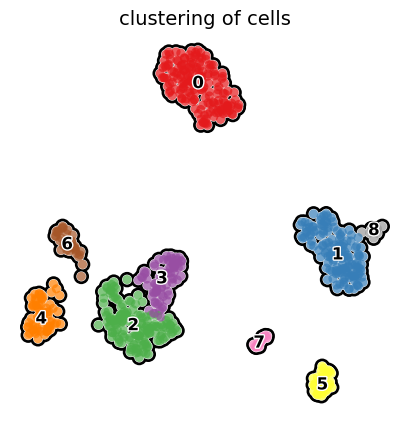

In [81]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(pbmc, color='clusters', add_outline=True, legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=2,frameon=False,
               title='clustering of cells', palette='Set1')

In [82]:
#Identifying clusters based on known markers
marker_genes_dict = {
    'B-cell': ['CD79A', 'MS4A1'],
    'Dendritic': ['FCER1A', 'CST3'],
    'Monocytes': ['FCGR3A'],
    'NK': ['GNLY', 'NKG7'],
    'Other': ['IGLL1'],
    'Plasma': ['IGJ'],
    'T-cell': ['CD3D'],
}

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


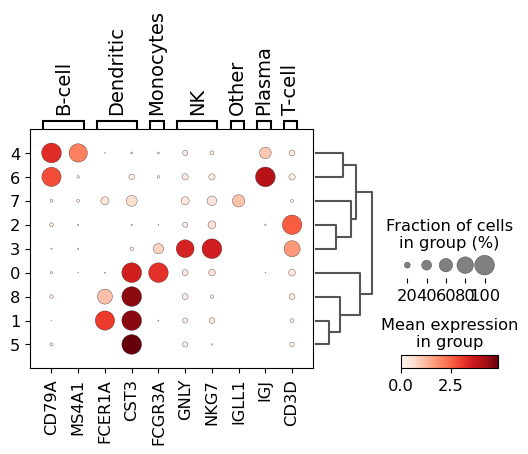

In [83]:
#dotplot
sc.pl.dotplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True)
#Using this plot, we can see that cluster 4 correspond to B-cells, cluster 2 is T-cells etc. 
# This information can be used to manually annotate the cells as follows:

In [84]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Monocytes',
     '1': 'Dendritic',
     '2': 'T-cell',
     '3': 'NK',
     '4': 'B-cell',
     '5': 'Dendritic',
     '6': 'Plasma',
     '7': 'Other',
     '8': 'Dendritic',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
pbmc.obs['cell type'] = pbmc.obs['clusters'].map(cluster2annotation).astype('category')

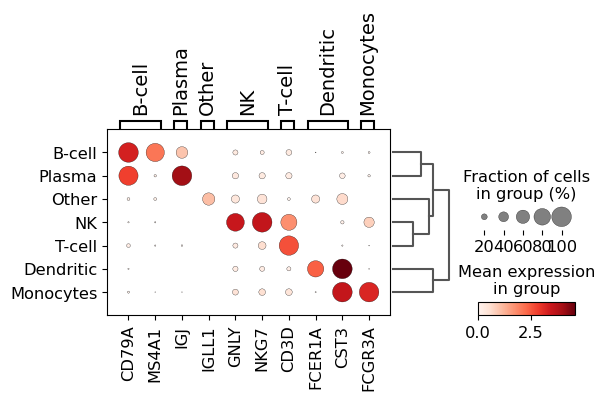

In [85]:
sc.pl.dotplot(pbmc, marker_genes_dict, 'cell type', dendrogram=True)

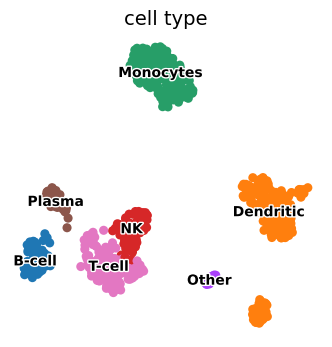

In [86]:
sc.pl.umap(pbmc, color='cell type', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

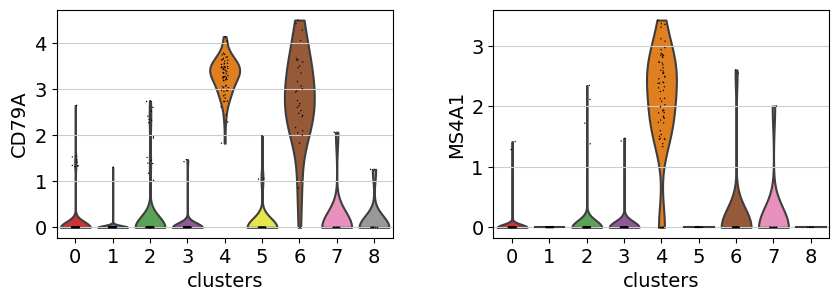

In [87]:
#violin plot
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(pbmc, ['CD79A', 'MS4A1'], groupby='clusters' )

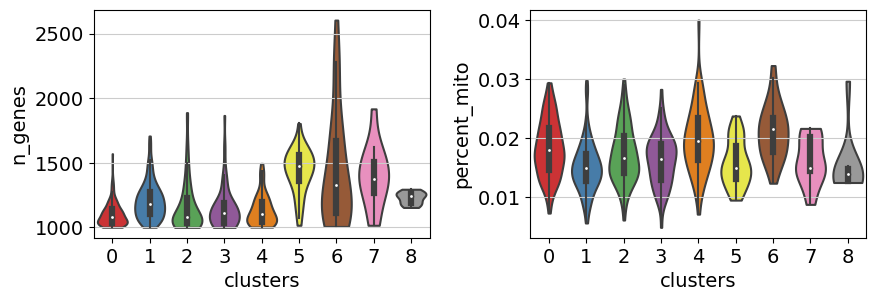

In [88]:
with rc_context({'figure.figsize': (4.5, 3)}):
    sc.pl.violin(pbmc, ['n_genes', 'percent_mito'], groupby='clusters', stripplot=False, inner='box')  
# use stripplot=False to remove the internal dots, inner='box' adds a boxplot inside violins

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


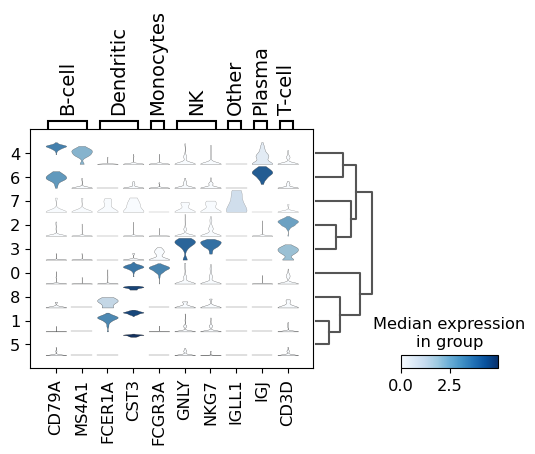

In [89]:
#stacked violin plot
ax = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='clusters', swap_axes=False, dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


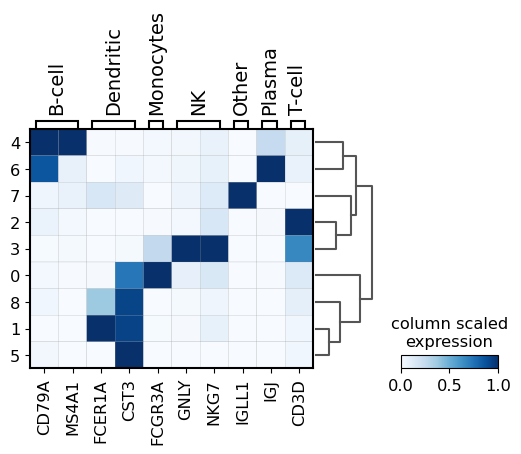

In [90]:
#Matrix plot
sc.pl.matrixplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True, cmap='Blues', standard_scale='var', colorbar_title='column scaled\nexpression')

In [91]:
# scale and store results in layer
pbmc.layers['scaled'] = sc.pp.scale(pbmc, copy=True).X

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.
/home/savita/.local/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


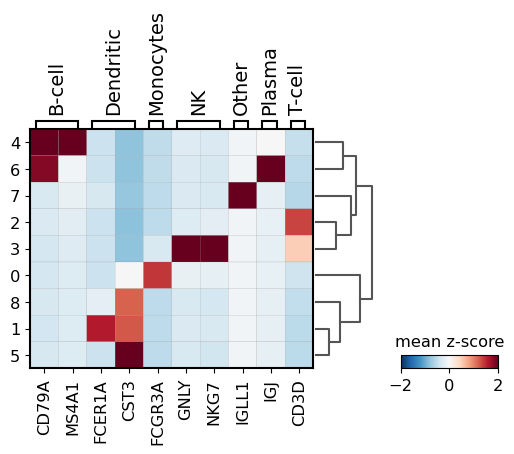

In [94]:
sc.pl.matrixplot(pbmc, marker_genes_dict, 'clusters', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

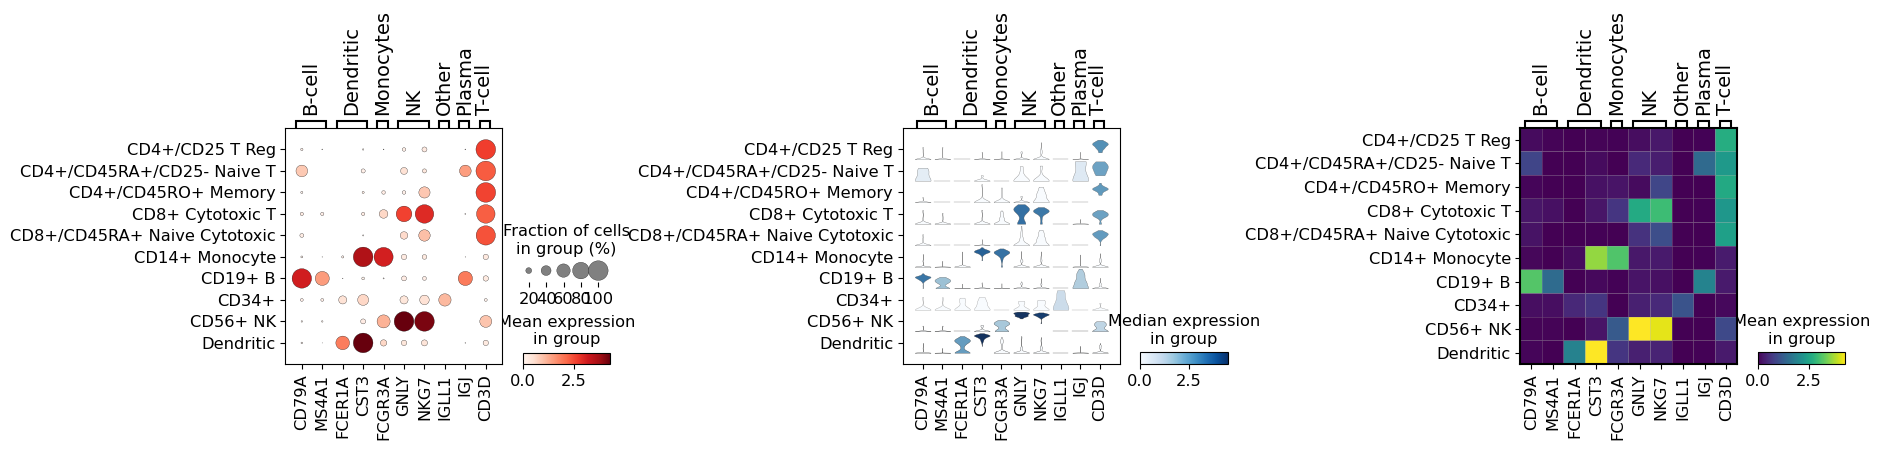

In [95]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4), gridspec_kw={'wspace':0.9})

ax1_dict = sc.pl.dotplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax1, show=False)
ax2_dict = sc.pl.stacked_violin(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax2, show=False)
ax3_dict = sc.pl.matrixplot(pbmc, marker_genes_dict, groupby='bulk_labels', ax=ax3, show=False, cmap='viridis')

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


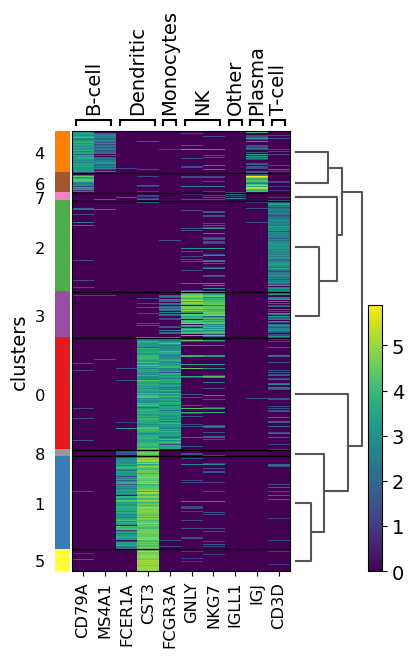

In [96]:
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby='clusters', cmap='viridis', dendrogram=True)

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


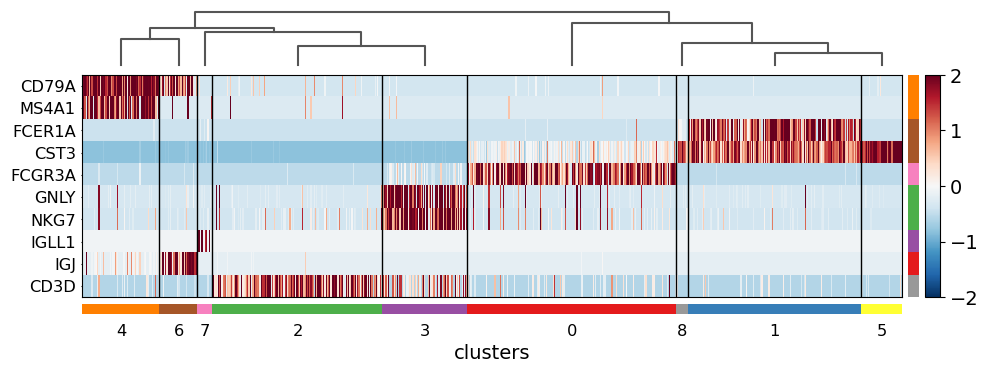

In [97]:
#Plotting heatmap on scaled data
ax = sc.pl.heatmap(pbmc, marker_genes_dict, groupby='clusters', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r', dendrogram=True, swap_axes=True, figsize=(11,4))

categories: 0, 1, 2, etc.
var_group_labels: B-cell, Dendritic, Monocytes, etc.


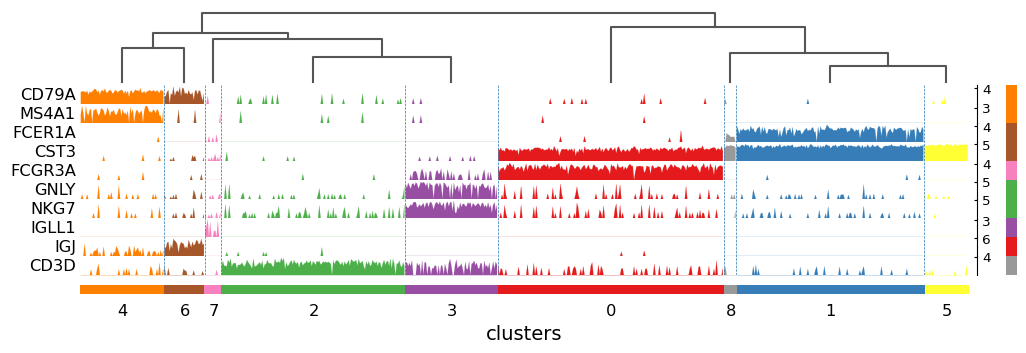

In [98]:
#Tracksplot: shows the same information as the heatmap, but, instead of a color scale, the gene expression is 
#represented by height.
ax = sc.pl.tracksplot(pbmc, marker_genes_dict, groupby='clusters', dendrogram=True)

In [99]:
#visualizing the differntially expressed marker genes as a dot plot
sc.tl.rank_genes_groups(pbmc, groupby='clusters', method='wilcoxon')

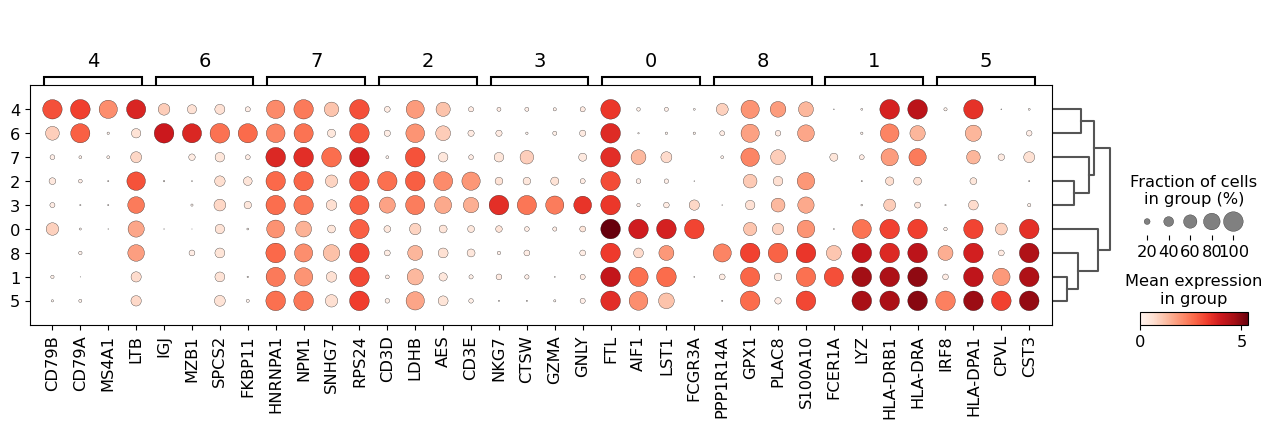

In [100]:
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4)

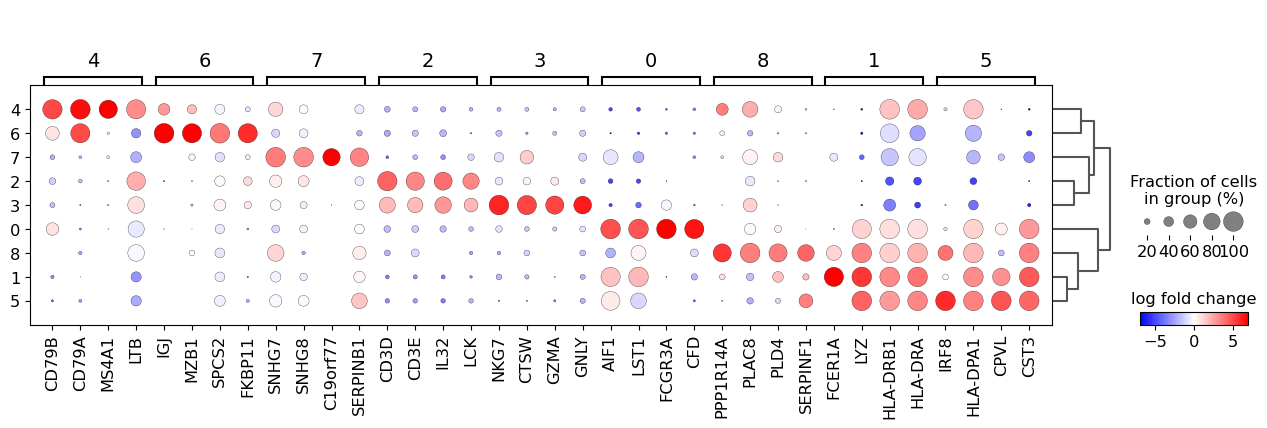

In [101]:
#Divergent color dotplot
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

categories: 0, 1, 2, etc.
var_group_labels: 1, 5


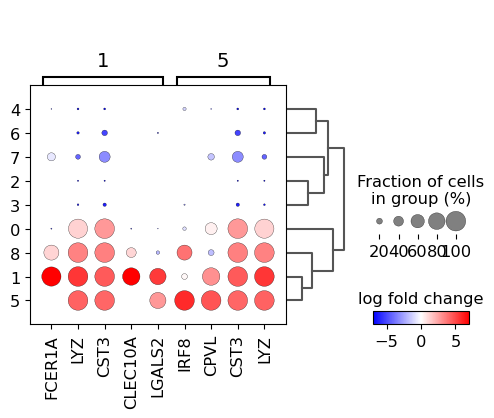

In [102]:
#Focusing on particular groups
#Here, we set n_genes=30 as in this case it will show all the genes that have a min_logfoldchange=4 up to 30
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=30, values_to_plot='logfoldchanges', min_logfoldchange=4, vmax=7, vmin=-7, cmap='bwr', groups=['1', '5'])

/home/savita/.local/lib/python3.8/site-packages/scanpy/plotting/_matrixplot.py:222: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  _ = ax.pcolor(_color_df, **kwds)


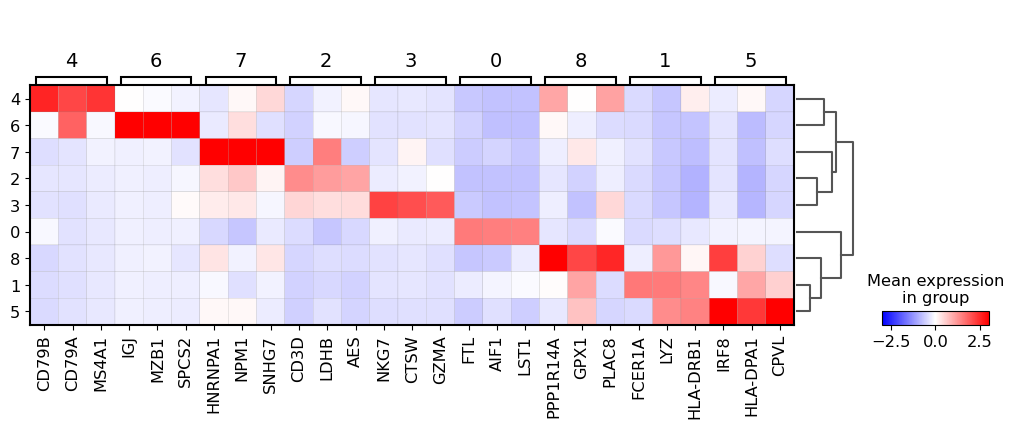

In [103]:
#visualizing marker genes using matrixplot
sc.pl.rank_genes_groups_matrixplot(pbmc, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap='bwr', layer='scaled')

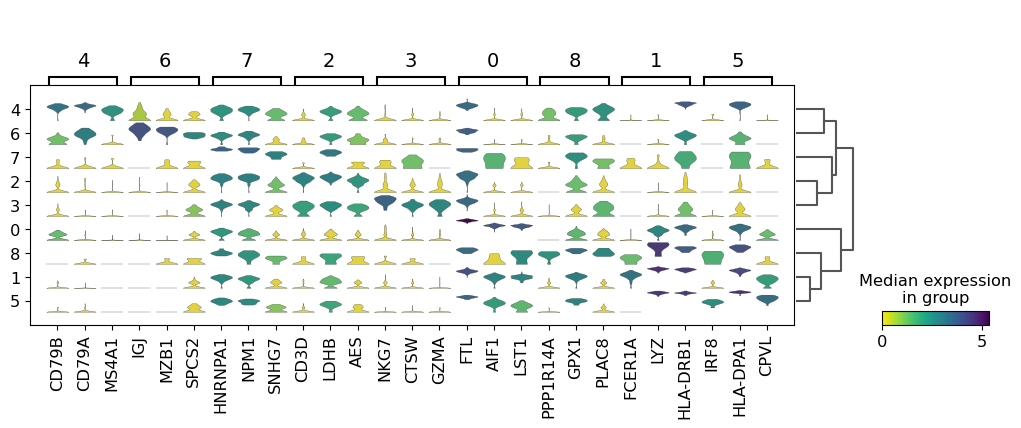

In [104]:
#visualize marker genes using stacked violin plots
sc.pl.rank_genes_groups_stacked_violin(pbmc, n_genes=3, cmap='viridis_r')

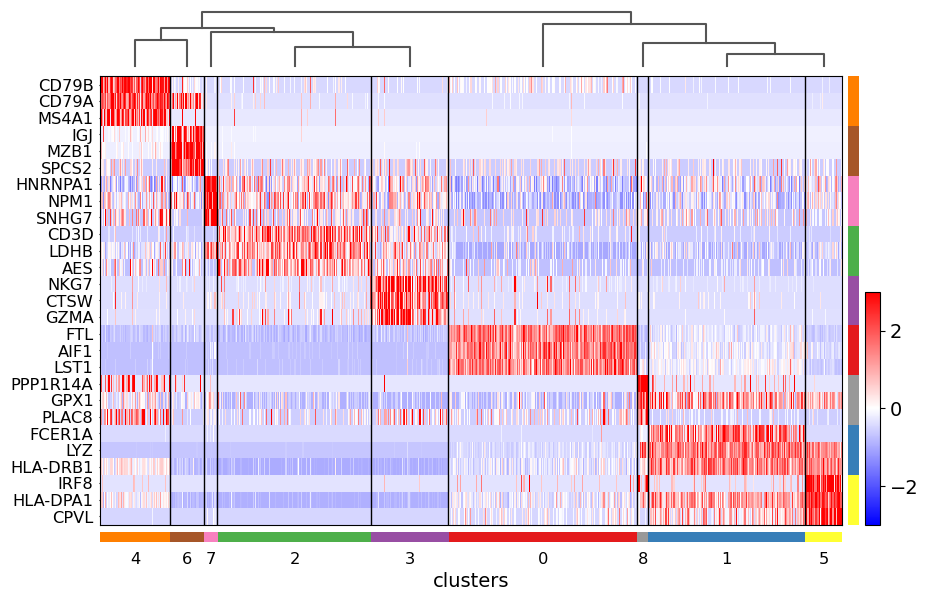

In [105]:
#visualize marker genes using heatmaps
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);

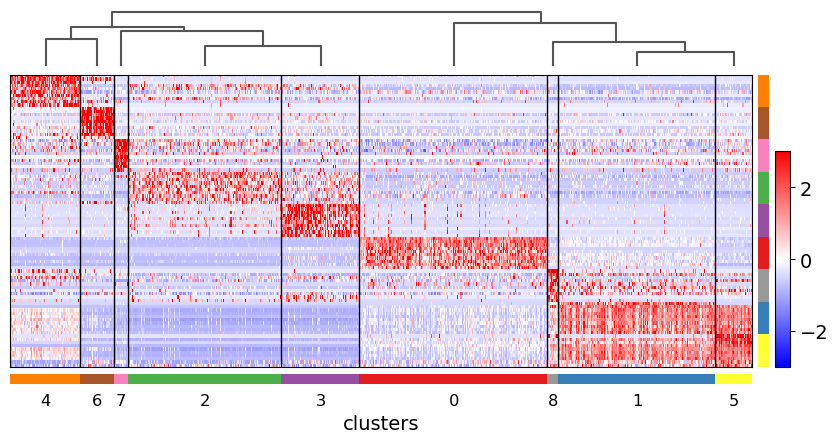

In [106]:
#showing 10 genes per category, turning gene labels off and swapping the axes
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=10, use_raw=False, swap_axes=True, show_gene_labels=False,
                                vmin=-3, vmax=3, cmap='bwr')

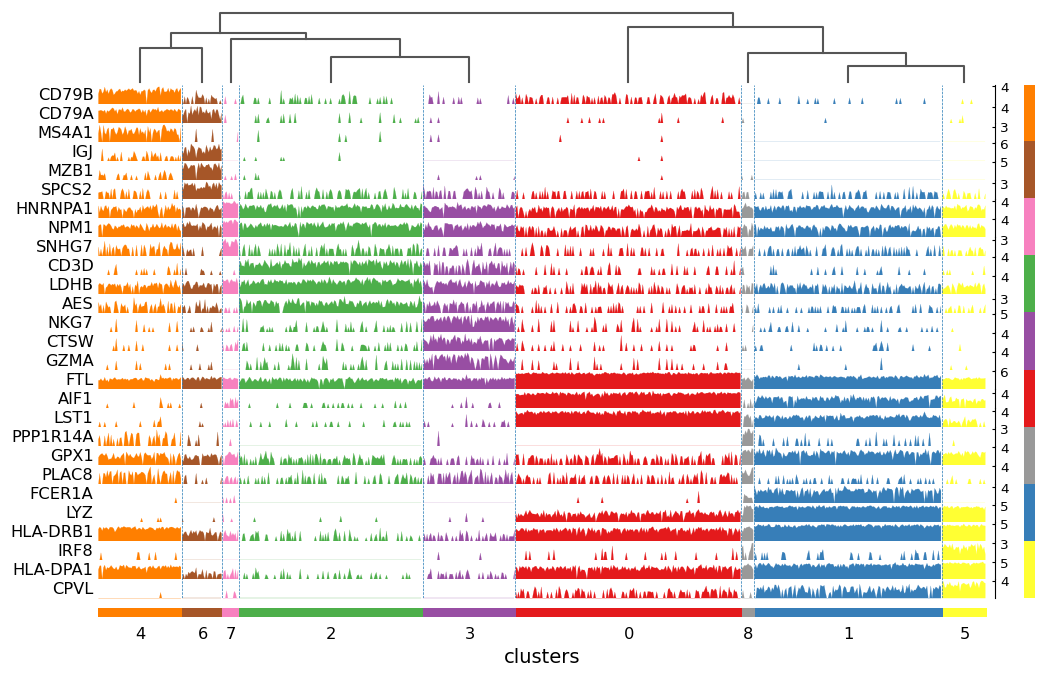

In [107]:
#visualize marker genes using traksplot
sc.pl.rank_genes_groups_tracksplot(pbmc, n_genes=3)

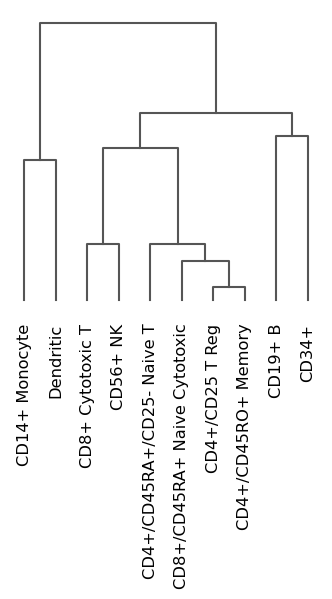

In [109]:
#Dendrograms
# compute hierarchical clustering using PCs (several distance metrics and linkage methods are available).
sc.tl.dendrogram(pbmc, 'bulk_labels')
ax = sc.pl.dendrogram(pbmc, 'bulk_labels')

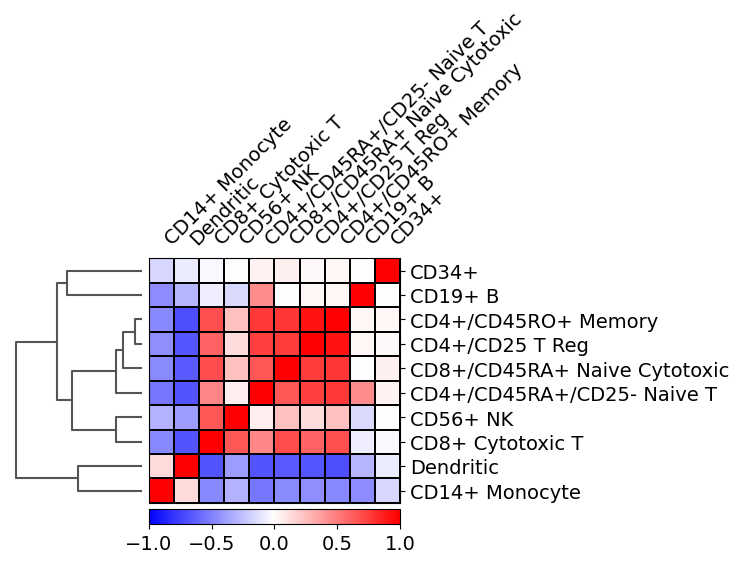

In [110]:
#correlation plots
ax = sc.pl.correlation_matrix(pbmc, 'bulk_labels', figsize=(5,3.5))